In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime,timedelta
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from time import time

In [2]:
df_catfish = pd.read_csv('catfish.csv',parse_dates=['Date'],index_col=0,squeeze=True)
df_catfish.head()

Date
1986-01-01     9034
1986-02-01     9596
1986-03-01    10558
1986-04-01     9002
1986-05-01     9239
Name: Total, dtype: int64

In [3]:
df_catfish = df_catfish.asfreq(pd.infer_freq(df_catfish.index))
df_catfish.head()

Date
1986-01-01     9034
1986-02-01     9596
1986-03-01    10558
1986-04-01     9002
1986-05-01     9239
Freq: MS, Name: Total, dtype: int64

In [4]:
startdate = datetime(1996,1,1)
enddate = datetime(2000,1,1)
df = df_catfish[startdate:enddate]
df.head()

Date
1996-01-01    20322
1996-02-01    20613
1996-03-01    22704
1996-04-01    20276
1996-05-01    20669
Freq: MS, Name: Total, dtype: int64

### Introduce an Anamoly

In [5]:
df[datetime(1998,12,1)] = 10000

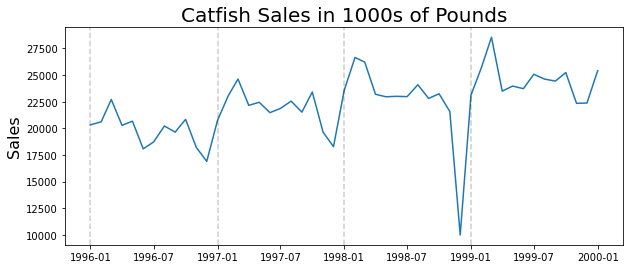

In [6]:
plt.figure(figsize=(10,4))
plt.plot(df)
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(startdate.year,enddate.year):
    plt.axvline(pd.to_datetime(str(year)), color='k', linestyle='--', alpha=0.2)

In [7]:
first_diff = df.diff()[1:]

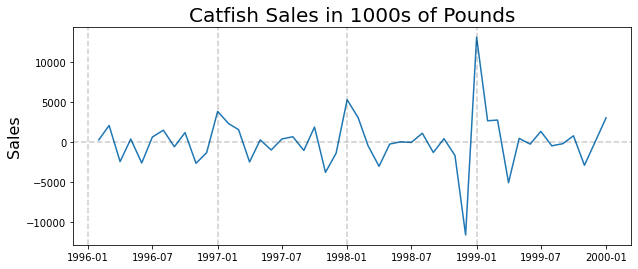

In [8]:
plt.figure(figsize=(10,4))
plt.plot(first_diff)
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(startdate.year,enddate.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axhline(0, color='k', linestyle='--', alpha=0.2)

In [9]:
train_end = datetime(1999,7,1)
test_end = datetime(2000,1,1)

test_data = df[train_end + timedelta(days=1):test_end]

In [10]:
my_order = (0,1,0)
my_seasonal_order = (1, 0, 1, 12)

In [11]:
rolling_predictions = test_data.copy()
for train_end in test_data.index:
    train_data = df[:train_end-timedelta(days=1)]
    model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order,initialization='approximate_diffuse')
    model_fit = model.fit()
    pred = model_fit.forecast()
    rolling_predictions[train_end] = pred

C:\Users\dasssvis\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:996: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\dasssvis\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1008: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


In [12]:
rolling_residuals = test_data - rolling_predictions

Text(0, 0.5, 'Error')

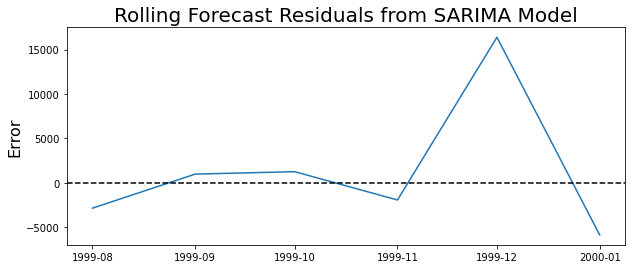

In [13]:
plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

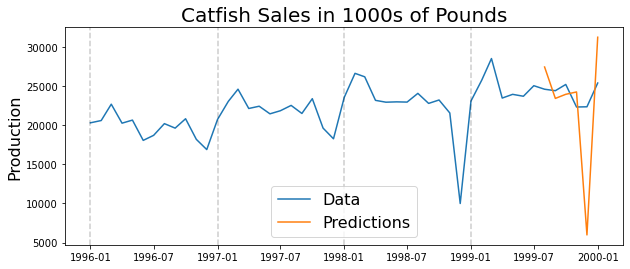

In [14]:
plt.figure(figsize=(10,4))
plt.plot(df)
plt.plot(rolling_predictions)
plt.legend(('Data', 'Predictions'), fontsize=16)
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(startdate.year,enddate.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [15]:
print('Mean Absolute Percent Error:', round(np.mean(abs(rolling_residuals/test_data)),4))

Mean Absolute Percent Error: 0.2092


In [16]:
print('Root Mean Squared Error:', np.sqrt(np.mean(rolling_residuals**2)))

Root Mean Squared Error: 7272.7329801113965


## Detecting the Anamoly

### Attempt 1: Deviation Method

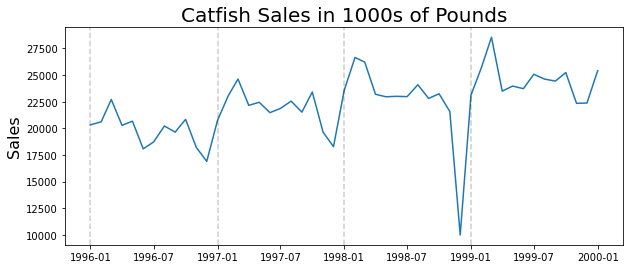

In [17]:
plt.figure(figsize=(10,4))
plt.plot(df)
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(startdate.year,enddate.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [18]:
rolling_deviations = pd.Series(dtype=float, index = df.index)
rolling_deviations.head()

Date
1996-01-01   NaN
1996-02-01   NaN
1996-03-01   NaN
1996-04-01   NaN
1996-05-01   NaN
Freq: MS, dtype: float64

In [19]:
for date in rolling_deviations.index:
    #get the window ending at this data point
    window = df.loc[:date]
    
    #get the deviation within this window
    rolling_deviations.loc[date] = window.std()

In [20]:
#get the difference in deviation between one time point and the next
diff_rolling_deviations = rolling_deviations.diff()
diff_rolling_deviations = diff_rolling_deviations.dropna()

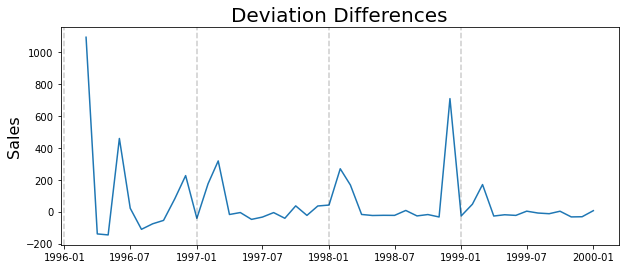

In [21]:
plt.figure(figsize=(10,4))
plt.plot(diff_rolling_deviations)
plt.title('Deviation Differences', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(startdate.year,enddate.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

### Attempt 2: Seasonal Method

In [22]:
month_deviations = df.groupby(lambda d: d.month).std()

Text(0, 0.5, 'Sales')

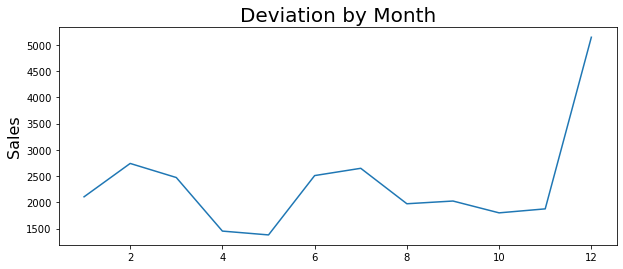

In [23]:
plt.figure(figsize=(10,4))
plt.plot(month_deviations)
plt.title('Deviation by Month', fontsize=20)
plt.ylabel('Sales', fontsize=16)

In [24]:
december_data = df[df.index.month == 12]

In [25]:
december_data

Date
1996-12-01    16898
1997-12-01    18278
1998-12-01    10000
1999-12-01    22372
Name: Total, dtype: int64

In [26]:
min_dev = 9999999
curr_anomaly = None
for date in december_data.index:
    other_data = december_data[december_data.index != date]
    curr_dev = other_data.std()
    if curr_dev < min_dev:
        min_dev = curr_dev
        curr_anomaly = date

In [27]:
curr_anomaly

Timestamp('1998-12-01 00:00:00')

In [28]:
adjusted_data = df.copy()
adjusted_data.loc[curr_anomaly] = december_data[(december_data.index != curr_anomaly) & (december_data.index < test_data.index[0])].mean()

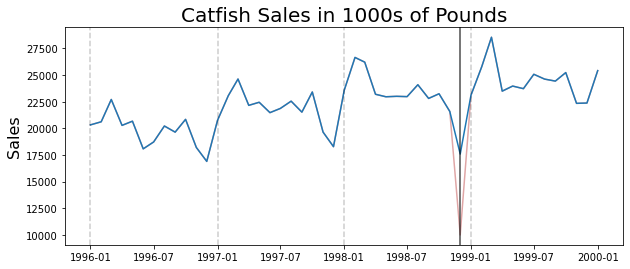

In [29]:
plt.figure(figsize=(10,4))
plt.plot(df, color='firebrick', alpha=0.4)
plt.plot(adjusted_data)
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(startdate.year,enddate.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axvline(curr_anomaly, color='k', alpha=0.7)

In [30]:
train_end = datetime(1999,7,1)
test_end = datetime(2000,1,1)

test_data = adjusted_data[train_end + timedelta(days=1):test_end]

In [31]:
rolling_predictions = test_data.copy()
for train_end in test_data.index:
    train_data = adjusted_data[:train_end-timedelta(days=1)]
    model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)
    model_fit = model.fit()

    pred = model_fit.forecast()
    rolling_predictions[train_end] = pred

C:\Users\dasssvis\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:996: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\dasssvis\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1008: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\dasssvis\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\dasssvis\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maxim

In [32]:
rolling_residuals = test_data - rolling_predictions

Text(0, 0.5, 'Error')

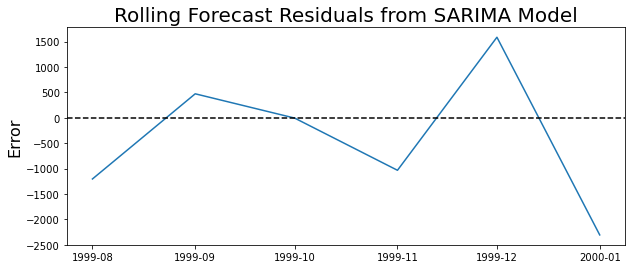

In [33]:
plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

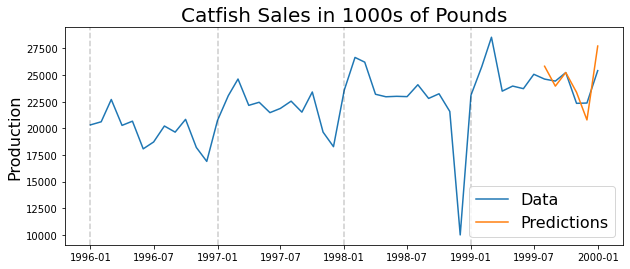

In [34]:
plt.figure(figsize=(10,4))

plt.plot(df)
plt.plot(rolling_predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(startdate.year,enddate.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [35]:
print('Mean Absolute Percent Error:', round(np.mean(abs(rolling_residuals/test_data)),4))

Mean Absolute Percent Error: 0.0461


In [36]:
print('Root Mean Squared Error:', np.sqrt(np.mean(rolling_residuals**2)))

Root Mean Squared Error: 1327.2630359754116
